In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from manage_experiments import *

from utils import generate_multidimensional_data_object_synthetic_geometric

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import json

In [38]:
import pathpy as pp
from collections import defaultdict 
def generate_tree_of_topics(max_depth = 3,branching_factor = 2,root = "*"):
    nodes_at_layer = defaultdict(list)
    # initializing the tree with root node and first layer
    start_nodes = [str(i) for i in range(branching_factor)]
    nodes_at_layer[0].append(root)
    nodes_at_layer[1].extend(start_nodes)
    for depth in range(2,max_depth+1):
        for node in nodes_at_layer[depth-1]:
            for base_node in start_nodes:
                nodes_at_layer[depth].append(node+base_node)

    # creating network object
    # children nodes connect to parent accoridn to condition below
    n = pp.Network(directed = True)
    for depth in range(max(nodes_at_layer)):
        if depth == 0:
            for node in nodes_at_layer[1]:
                n.add_edge(root,node)
        else:
            for node_parent in nodes_at_layer[depth]:
                for node_child in nodes_at_layer[depth+1]:
                    # condition
                    if node_child[:-1]==node_parent:
                        n.add_edge(node_parent,node_child)
    return n


def assign_skills(n, study_hours, tau = 0, root="*"):
    # gives skills to students
    # we start by taking one random path from root to leaf for each student
    # EXTENSIONS goes in the direction of using personalized pagerank from the root node and would include: 
    #   study hours (similar to ability, encodes number of transitions taken by the students rw)
    #   restart probability tau at any node
    #   once an end node is reached, student restards from prev visited node (or root) with prob 1
    #
    # for now just enough to reach one leaf
    T = n.transition_matrix().todense().T
    root_index = n.node_to_name_map()[root]
    ix_to_node = {v:k for k,v in n.node_to_name_map().items()}
    last_node_ix = root_index
    # saving what topics have been traversed
    traversed_topics = set()
    # random walk
    studied_hours = 0
    while studied_hours < study_hours:
        # random restart (from root) probability
        if np.random.rand() < tau:
            last_node_ix = root_index
        # reached a leaf node, save the topic and restart from root
        if np.isclose(sum(T[last_node_ix,:].tolist()[0]),0.0):
            last_node_ix = root_index
        next_nodes_probability = T[last_node_ix,:].tolist()[0]
        # If not in leaf node, and no random restart from root, randomly follow an edge to chidren node
        last_node_ix = np.random.choice(range(n.ncount()),p=next_nodes_probability)
        current_topic = ix_to_node[last_node_ix]
        # if topics has not been traversed, add one study hour
        if current_topic not in traversed_topics:
            traversed_topics.add(current_topic)
            studied_hours+=1
    return traversed_topics #ix_to_node[last_node_ix]
    # NB: could potentially keep only the nodes further down the tree


def generate_observations_tree_of_topics(n, n_students : int, n_items : int,tree_depth :int, branching_factor:int, p_ER = .3,skill_mismatch_penalty = 100):
    """
    Assigns topics to items and skills to items based on the tree of topics. 
    Then, generates observations. 
    """
    # ASSIGN TOPICS TO ITEMS AND SKILLS TO STUDENTS
    #
    # TASKS:
    topics = list(set(n.nodes).difference({"*"}))
    # NB: randomly sampling nodes will disproportionately give leaves, i.e., difficult items.
    # equal probability to each layer, then equal for each node in the layer
    # layer_probability = np.ones(tree_depth)/tree_depth 
    # probability proportional to number of nodes in each layer (i.e., similar to randomly sampling a node)
    # layer_probability = [branching_factor**l/sum([branching_factor**i for i in range(1,tree_depth+1)]) for l  in range(1,tree_depth+1)]
    # probability of sampling from one layer is proportional to the layer number
    layer_probability = np.arange(1,tree_depth+1)/ np.arange(1,tree_depth+1).sum()
    item_topics = np.random.choice(a=topics,size=n_items, p = [layer_probability[len(t)-1]/(branching_factor**(len(t))) for t in topics], replace=True)
    dict_items_topics = dict(zip(range(n_items),item_topics))
    #
    # STUDENTS
    dict_students_skills = {stud_id:set() for stud_id in range(n_students)}
    for stud_id in dict_students_skills:
        # TODO: deal with these parameters
        study_hours = np.random.choice([round(i) for i in np.linspace(tree_depth,min(sum([branching_factor**i for i in range(1,tree_depth+1)]),tree_depth*10),10)])
        dict_students_skills[stud_id].update(assign_skills(n,study_hours))
    print("Skills assignment completed!")
    # GENERATE OBSERVATIONS
    # students interact randomly with items (erdos renyi). Student pass items if they have traversed the topic/tree-node in their learning path
    edges = []
    labels = []
    # TODO: could save p of passing and then adjust adjust a threshold to avoid or diminis the imbalance in the classification
    for stud_id in dict_students_skills:
        for item_id in dict_items_topics:
            if np.random.rand()<p_ER:
                edges.append((stud_id,item_id))
                # deciding if item is passed
                # could be made more nuanced checking how much of the path to the item_topic has been traversed by the student
                item_topic = dict_items_topics[item_id] 
                student_skills = dict_students_skills[stud_id]
                # number of steps (in the tree) needed to go from skills available to the student to the ones necessary to pass the task
                steps_to_topic = 0
                p_of_passing = 1
                while ((item_topic[:-steps_to_topic] if steps_to_topic!=0 else item_topic) not in student_skills) and (steps_to_topic <= tree_depth):
                    steps_to_topic+=1
                p_of_passing = p_of_passing/((branching_factor+skill_mismatch_penalty)**(steps_to_topic))
                if p_of_passing >= np.random.rand():
                    labels.append(1)
                else:
                    labels.append(0)
    print("Balaceness",sum(labels)/len(labels))
    return edges, labels


import torch_geometric.transforms as T
def create_data_object_synthetic_tree_topics(n_students,n_tasks,edge_indices, y):
    data  = HeteroData()

    # Save node indices
    data['student'].node_id = torch.arange(n_students)
    data['item'].node_id = torch.arange(n_tasks)


    # Add the node features
    data['student'].x= torch.eye(n_students)
    data['item'].x = torch.eye(n_tasks)

    # Add the edge indices
    data['student', 'responds', 'item'].edge_index = torch.from_numpy(np.array(edge_indices).T).to(torch.long)

    #add the edge attrs
    data['student', 'responds', 'item'].edge_attr = torch.tensor([1]*len(y)).to(torch.float).reshape(-1,1)

    # Add the edge label
    data['student', 'responds', 'item'].y = torch.from_numpy(np.array(y)).to(torch.long)

    # We use T.ToUndirected() to add the reverse edges from subject to students 
    # in order to let GNN pass messages in both ways
    data = T.ToUndirected()(data)
    del data['item', 'rev_responds', 'student'].edge_attr  # Remove 'reverse' label.
    del data['item', 'rev_responds', 'student'].y  # Remove 'reverse' label.
    return data


def generate_data_object_synthetic_tree_topics(n_students, n_tasks, tree_depth,branching_factor=2, p_ER =.3, skill_mismatch_penalty = 100):
    n = generate_tree_of_topics(tree_depth, branching_factor)
    edges, labels = generate_observations_tree_of_topics(n, n_students, n_tasks, tree_depth,branching_factor,p_ER,skill_mismatch_penalty)
    data = create_data_object_synthetic_tree_topics(n_students,n_tasks,edges, labels)
    print("network density",data.num_edges/(2*n_students*n_tasks))
    return data


data_object = generate_data_object_synthetic_tree_topics(n_students = 720, n_tasks = 280, tree_depth = 3,branching_factor=4, p_ER =.5)
data_object

Skills assignment completed!
Balaceness 0.3172639278118975
network density 0.49913690476190475


HeteroData(
  student={
    node_id=[720],
    x=[720, 720],
  },
  item={
    node_id=[280],
    x=[280, 280],
  },
  (student, responds, item)={
    edge_index=[2, 100626],
    edge_attr=[100626, 1],
    y=[100626],
  },
  (item, rev_responds, student)={ edge_index=[2, 100626] }
)

In [10]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def line_plot_with_std(list_scores, parameters, fname):

    # Convert the list of lists to a Pandas DataFrame
    df = pd.DataFrame(list_scores)

    # Calculate the mean and standard deviation of each row
    mean = df.mean(axis=1)
    std = df.std(axis=1)

    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Plot the mean line
    ax.plot(mean, color='blue', label='Mean')

    # Plot the shaded region around the mean line
    ax.fill_between(df.index, mean-std, mean+std, color='lightblue', alpha=0.5, label='Standard deviation')

    # Add some labels and a legend
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    # ax.legend()

    # change x-ticks to start from 
    n_tasks_per_student_list = list(range(
        parameters['min_n_tasks_per_student'],
        parameters['max_n_tasks_per_student'],
        parameters['step_n_tasks_per_student']))
    ax.set_xticks(range(len(n_tasks_per_student_list)), n_tasks_per_student_list, rotation=45)

    # Show and save the plot
    plt.grid()
    plt.xlabel('Number of tasks per student')
    plt.ylabel('Balanced Accuracy')
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)
    # plt.show()


In [11]:
def visualise_confusion_matrix(json_content, fname):
    fig, ax = plt.subplots(ncols = 1, figsize=(8,6))
    
    plt.imshow(json_content["Confusion_2_test"], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = [0, 1]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    part1, part2 = fname.split('.')
    part1 = part1 + '_consfusion_matrix'
    fname = '.'.join([part1, part2])
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)

In [12]:
from IPython.utils import io
import matplotlib.pyplot as plt

import string
def create_filename_results(parameters,fold):
    file_name = ' '.join([f"{str(key)}-{str(value)}" for key, value in parameters.items() if key not in ['max_n_tasks_per_student','min_n_tasks_per_student']])
    file_name += ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(4))
    file_name.replace(".","")
    file_name+=".results"
    return os.path.join(fold, file_name)


#n_students_per_task_list = [2**i for i in n_students_per_task_list]

import json
def synthetic_density_effect_runs(parameters,parameters_density, folder = 'synth_density_effect'):
    parameters = {**parameters, **parameters_density}
    scores = []
    list_scores = []
    for _ in range(parameters["n_runs"]):
        with io.capture_output() as captured:
            data = generate_data_object_synthetic_tree_topics(
                n_students = parameters['n_students'], 
                n_tasks = parameters['n_tasks'],
                tree_depth=parameters["tree_depth"],
                branching_factor=parameters["branching_factor"],
                p_ER=parameters["p_ER"],
                skill_mismatch_penalty=parameters["skill_mismatch_penalty"])

            cv_out = perform_cross_validation(data, parameters, save_embeddings=True)

            score = 0
            inner_list_scores = []
            for fold_n in range(parameters["n_splits"]):
                score += cv_out[f"Balanced Accuracy_{fold_n}_test"]
                inner_list_scores.extend([cv_out[f"Balanced Accuracy_{fold_n}_test"]])
            score = score / parameters["n_splits"]
            scores.append(score)
            list_scores.append(inner_list_scores)

    density = data.num_edges/(2*parameters["n_students"]*parameters["n_tasks"]) 
    res_dict = dict(zip(list(range(parameters["n_runs"])),scores))
    output_dict = {
        **parameters,
        "density":density,
        "res_dict":res_dict,
        "list_scores":dict(zip(list(range(parameters["n_runs"])),list_scores))
    }
    fname = create_filename_results(parameters_density, folder)
    with open(fname,'w') as f:
        json.dump(output_dict, f, skipkeys=True)
    
    # save results
    # print(density)
    print([np.mean(s) for s in list_scores])
    # line_plot_with_std(list_scores=list_scores, parameters= parameters, fname=fname)

    # # save embeddings
    # visualise_embeddings(output_dict, fname=fname)

    # visualise_embeddings_concatenated(output_dict, data['student', 'responds', 'item'].edge_index, data['student', 'item'].y, fname = fname) # plot with indices of train-test split
    
    # # plot with indices of train-test split
    


    # visualise_confusion_matrix(cv_out, fname=fname)

In [41]:
parameters = {
    "hidden_dims": None,
    'model_type': None,
    "df_name": "synthetic.salamoia",
    "method": "EdgeClassifier",
    "epochs": 1000,
    "learning_rate": 0.05,
    "weight_decay": 0,
    "dropout": 0.0,
    "early_stopping": 250,
    "n_splits": 10,
    "device": "cuda",
    "done": False,
    "batch_size":128,
    #
    }

parameters_density = {
    'n_students' :720, # 72% of nodes were students
    'n_tasks':280,
    'n_runs':10,
    'tree_depth':None,
    'branching_factor':None,
    'p_ER':None, 
    'skill_mismatch_penalty': None
}


In [42]:
# https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
# def seed_everything(seed: int):
#     import random, os
#     import numpy as np
#     import torch
    
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True

In [46]:
# NB: having only the leaves might make it easier for IRT since it just creates separated bins (i.e., the leaves) and easy tasks (the ones sampled close to the root node)
#  Instead, with a GNN we want to leverage the ...ability to encode the underlying tree structure (HOW might the GNN do it, specifically?)
depths = [4,5,6,7,8]
branching_factors = [2,3,4]
p_ERs = [.1,.3,.5]
smps = [0,1000]

for tree_depth in depths:
    parameters_density['tree_depth'] = tree_depth
    print()
    print('Tree depth ', tree_depth)
    for branching_factor in branching_factors:
        parameters_density['branching_factor'] = branching_factor
        print('branching_factor', branching_factor)
        for p_ER in p_ERs:
            parameters_density['p_ER'] = p_ER
            print('p_ER', p_ER)
            for smp in smps:
                parameters_density['skill_mismatch_penalty'] = smp
                print('skill_mismatch_penalty', smp)
                for model_type,hidden_dims in [
                    ("IRT",3),
                    ("GNN", [
                        16,
                        16,
                        8])]:
                    print(model_type)
                    parameters["model_type"] = model_type
                    parameters["hidden_dims"] = hidden_dims
                    synthetic_density_effect_runs(parameters=parameters,
                                                parameters_density=parameters_density,
                                                )


Tree depth  4
branching_factor 2
p_ER 0.1
skill_mismatch_penalty 0
IRT
[0.5435278612472556, 0.5578846602681106, 0.549077114529971, 0.5539659548853978, 0.5567361439279589, 0.5562225323803839, 0.5557375287324294, 0.5530060343648939, 0.5410399640883147, 0.5550035633670398]
GNN


KeyboardInterrupt: 

In [ ]:
import numpy as np

In [ ]:
def sigmoid(x, alpha):
    return 1/(1+np.exp(-x/alpha))

C:\Users\liq02qc\AppData\Local\Temp\ipykernel_32752\1727097957.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(1+np.exp(-x/alpha))
C:\Users\liq02qc\AppData\Local\Temp\ipykernel_32752\1727097957.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return 1/(1+np.exp(-x/alpha))


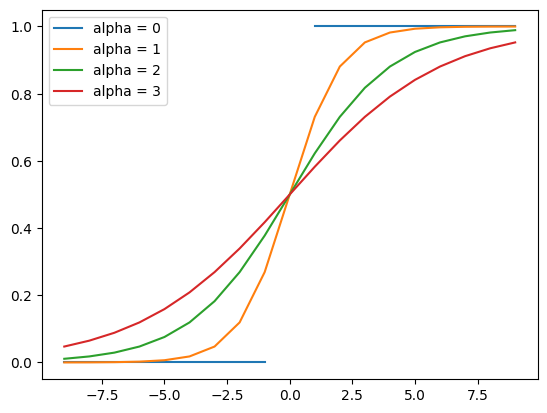

In [ ]:
x = np.arange(-9,10)
plt.plot(x, [sigmoid(xi,0) for xi in x], label="alpha = 0")
plt.plot(x, [sigmoid(xi,1) for xi in x], label="alpha = 1")
plt.plot(x, [sigmoid(xi,2) for xi in x], label="alpha = 2")
plt.plot(x, [sigmoid(xi,3) for xi in x], label="alpha = 3")
plt.legend()

In [ ]:
import pathpy as pp
from collections import defaultdict 
import copy
# tree
root = "*"
max_depth = 3
nodes_at_layer = defaultdict(list)
nodes_at_layer[0].append(root)
start_nodes = ["0","1"]
nodes_at_layer[1].extend(start_nodes)
for depth in range(2,max_depth+1):
    # nodes_this_layer = []
    # nodes_prev_layer = copy.deepcopy(nodes_at_layer[depth-1])
    for node in nodes_at_layer[depth-1]:
        for base_node in start_nodes:
            nodes_at_layer[depth].append(node+base_node)


nodes_at_layer

defaultdict(list,
            {0: ['*'],
             1: ['0', '1'],
             2: ['00', '01', '10', '11'],
             3: ['000', '001', '010', '011', '100', '101', '110', '111']})

In [ ]:
n = pp.Network(directed = True)
for depth in range(max(nodes_at_layer)):
    if depth == 0:
        for node in nodes_at_layer[1]:
            n.add_edge(root,node)
    else:
        for node_parent in nodes_at_layer[depth]:
            for node_child in nodes_at_layer[depth+1]:
                if node_child[:-1]==node_parent:
                    n.add_edge(node_parent,node_child)
print(n.ncount())
pp.visualisation.plot(n, width = 800,height = 800)

15


In [ ]:
nodes = list(n.nodes)
n_items = 100
# NB: randomly sampling nodes will disproportionately give leaves, i.e., difficult items.
item_positions = np.random.choice(nodes,size=n_items)
dict_item_positions = dict(zip(range(n_items),item_positions))

In [ ]:
def assign_skills(n, study_hours,root="*"):
    # gives skills to students
    # we start by taking one random path from root to leaf for each student
    # extensions goes in the direction of using personalized pagerank from the root node and would include: 
    #   study hours (similar to ability, encodes number of transitions taken by the students rw)
    #   restart probability tau at any node
    #   once an end node is reached, student restards from prev visited node (or root) with prob 1
    #
    # for now just enough to reach one leaf
    T = n.transition_matrix().todense().T
    root_index = n.node_to_name_map()[root]
    ix_to_node = {v:k for k,v in n.node_to_name_map().items()}
    last_node_ix = root_index
    for _ in range(study_hours):
        last_node_ix = np.random.choice(range(n.ncount()),p=T[last_node_ix,:].tolist()[0])
    return ix_to_node[last_node_ix]


n_students = 100
dict_students_abilities = {stud_id:[] for stud_id in range(n_students)}
for stud_id in dict_students_abilities:
    # append, but potentially extend cause students can get skills in different branches
    dict_students_abilities[stud_id].append(assign_skills(n,depth+1))
# dict_students_abilities

In [ ]:
# students interact randomly with items (erdos renyi). Student pass items if they have traversed the topic/tree-node in their learning path
p_ER = .3
edges = []
labels = []
for stud_id in dict_students_abilities:
    for item_id in dict_item_positions:
        if np.random.rand()<p_ER:
            edges.append((stud_id,item_id))
            # deciding if item is passed
            # could be made more nuanced checking how much of the path to the item_topic has been traversed by the student
            item_topic = dict_item_positions[item_id] 
            student_skills = dict_students_abilities[stud_id]
            if any([item_topic==skill[:len(item_topic)] for skill in student_skills if len(skill)>=len(item_topic)]):
                labels.append(1)
            else:
                labels.append(0)

print(sum(labels)/len(labels))

0.21070346684617974


HeteroData(
  student={
    node_id=[100],
    x=[100, 100],
  },
  item={
    node_id=[100],
    x=[100, 100],
  },
  (student, responds, item)={
    edge_index=[2, 2927],
    edge_attr=[2927, 1],
    y=[2927],
  },
  (item, rev_responds, student)={ edge_index=[2, 2927] }
)

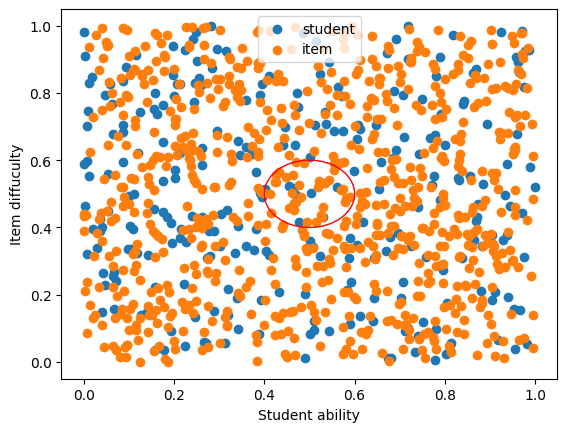

In [ ]:
# GENERATING NODE POSITIONS AND PLOTTING THEM 
# NB: ALSO SETTING RADIUS USED BELOW

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
dimension = 2
n_students = 270
n_items = 750
#
student_geom = np.random.rand(n_students,dimension)
student_ids = range(n_students)
items_geom = np.random.rand(n_items,dimension)
items_id = range(n_students, n_students+n_items)
#
radius = .1
fig,ax = plt.subplots()
ax.scatter(student_geom[:,0],student_geom[:,1], label = "student")
ax.scatter(items_geom[:,0],items_geom[:,1], label = "item")
plt.xlabel("Student ability")
plt.ylabel("Item diffuculty")
circle = Circle([.5,.5], radius, fill=False, edgecolor='red')
ax.add_patch(circle)
plt.legend()


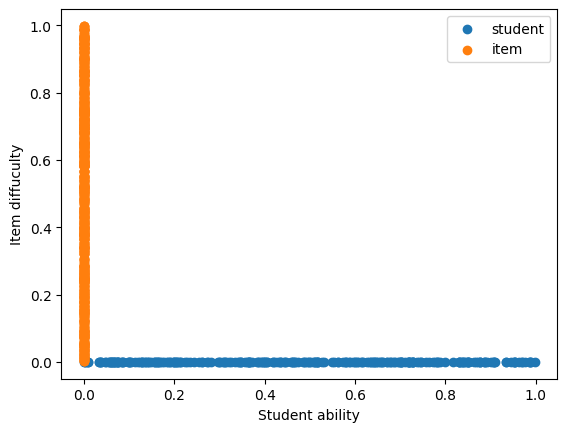

In [ ]:
# GENERATING NODE POSITIONS AND PLOTTING THEM 
# NB: ALSO SETTING RADIUS USED BELOW

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
dimension = 2
n_students = 270
n_items = 750
#
student_geom = np.random.rand(n_students,dimension)
student_ids = range(n_students)
items_geom = np.random.rand(n_items,dimension)
items_id = range(n_students, n_students+n_items)
#
radius = .1
fig,ax = plt.subplots()
ax.scatter(student_geom[:,0],[0]*len(student_geom[:,1]), label = "student")
ax.scatter([0]*len(items_geom[:,0]),items_geom[:,1], label = "item")
plt.xlabel("Student ability")
plt.ylabel("Item diffuculty")
# circle = Circle([.5,.5], radius, fill=False, edgecolor='red')
# ax.add_patch(circle)
plt.legend()

In [ ]:
np.random.rand()

0.24944365643741484

In [ ]:
n_students = 100
n_items = 150

list_a = [np.random.randint(50)/50 for _ in range(n_students)]
list_i = [np.random.randint(50)/50 for _ in range(n_items)]

edges = []
for i in range(n_students):
    # ability student i
    a_i = list_a[i]
    for j in range(n_items):
        # difficulty item j
        d_j = list_i[j]
        # delta gives how appropriate taks diff is for student ability
        delta = abs(a_i - d_j)
        # probability of interaction prop to inverse of delta: 
        p_i_j = 1/(2+delta)**4
        assert p_i_j <= 1
        if np.random.rand()<p_i_j:
            edges.append((i,i+j))

In [ ]:
import pathpy as pp
n = pp.Network(directed=True)
for (u,v) in edges:
    n.add_edge(u,v)
pp.visualisation.plot(n, width =800,height = 800)

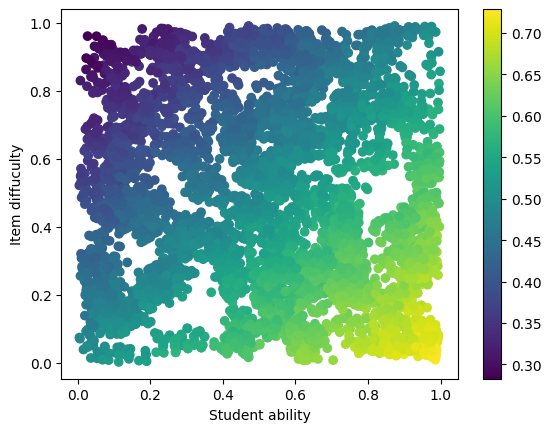

In [ ]:
# OBTAINING PROBABILITY (AND PLOTTING PATTERNS FOR ON EDGES -- POSITION TAKING AVERAGE BETWEEN NODES INVOLVED IN THE INTERACTIONS)
label_probs = []
list_edge_points = []
for i in range(n_students):
    for j in range(n_items):
        if np.linalg.norm(student_geom[i]-items_geom[j]) < radius:
            # first coordinate used as student ability 
            # second coordinate used as item difficulty
            x = student_geom[i][0]-items_geom[j][1]
            label_probs.append(1/(1+np.exp(-x)))
            list_edge_points.append((student_geom[i]+items_geom[j])/2)

list_edge_points = np.array(list_edge_points)
plt.xlabel("Student ability")
plt.ylabel("Item diffuculty")
plt.scatter(list_edge_points[:,0],list_edge_points[:,1], c=label_probs)
plt.colorbar()

In [ ]:

# # CREATING LIST OF EDGES
# # import pathpy as pp
# import numpy as np
# n = pp.Network()
# edges = []
# for i in range(n_students):
#     for j in range(n_items):
#         if np.linalg.norm(student_geom[i]-items_geom[j]) < radius:
#             edges.append((i,i+j))
#             n.add_edge(i,n_students+j)


# # COOL DRAGON-LIKE VISUALIZATION
# # pp.visualisation.plot(n, width =800,height = 800)